In [25]:
import pandas as pd
import numpy as np
import pickle
import time

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

import spacy
import scispacy
import en_core_sci_lg
from spacy_langdetect import LanguageDetector
from spacy.language import Language

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim import matutils, models
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import scipy.sparse


/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [13]:
with open("./data/clean_df.pkl", "rb") as read_file:
    df = pickle.load(read_file)
df.head()

,cord_uid,source_x,title,doi,abstract,publish_time,authors,journal,url,publish_year
0,gl6kg2gt,WHO,Progress Toward Poliovirus Containment Impleme...,NaN,"Since 1988, when World Health Organization (WH...",2020-01-01,"Moffett, Daphne B; Llewellyn, Anna; Singh, Har...",MMWR Morb Mortal Wkly Rep,NaN,2020
1,jjgqnzp6,WHO,Anti)social Monitoring: Law and (or) Expediency?,NaN,The paper is focused on analysis of compliance...,2020-01-01,"Savelyev, Alexander I.",Zakon,NaN,2020
2,s5hd55ch,WHO,Running of high patient volume radiation oncol...,NaN,"Purpose: Due to COVID 19 pandemic, the treatme...",2020-01-01,"Gupta, Manoj; Ahuja, Rachit; Gupta, Sweety; Jo...",Radiat. Oncol. J.,NaN,2020
3,zl9kf1ax,MedRxiv; WHO,Rapid Development of a De Novo Convalescent Pl...,10.1101/2020.10.23.20217901,BackgroundWith no vaccine or treatment for SAR...,2020-01-01,"Reik, Rita; Gammon, Richard; Carol, Nancy; Smi...",NaN,http://medrxiv.org/cgi/content/short/2020.10.2...,2020
4,gzjfyitd,WHO,COVID – 19 and gravid mothers,NaN,Human history is observing a very horrible and...,2020-01-01,"Sadavarte, S.; Chaudhari, B. V.",International Journal of Research in Pharmaceu...,NaN,2020


In [14]:
all_texts = df.abstract
len(all_texts)

268611

In [15]:
# spacy nlp model
nlp = en_core_sci_lg.load()
nlp.max_length=3000000

In [16]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [17]:
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, min_df=2)
data_vectorized = vectorizer.fit_transform(all_texts)

In [19]:
pickle.dump(data_vectorized, open("data_vect.pkl", "wb"))

In [21]:
pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))

<AxesSubplot:ylabel='word'>

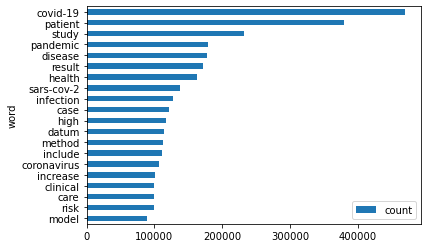

In [22]:
# most frequent words
word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 
                           'count': np.asarray(data_vectorized.sum(axis=0))[0]})
word_count.sort_values('count', ascending=False).set_index('word')[:20]\
                .sort_values('count',ascending=True).plot(kind='barh')

## LDA

In [26]:
# LDA - sklearn
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(data_vectorized)

LatentDirichletAllocation(random_state=0)

In [28]:
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words -1: -1]])
        print(message)
    print()

In [29]:
print_top_words(lda, vectorizer, n_top_words=25)


Topic #0: model datum case covid-19 result method number time system study propose base different analysis rate epidemic estimate network measure spread transmission control approach provide disease

Topic #1: care study health student pandemic patient include result research covid-19 review support provide online method service experience intervention use need clinical practice medical education datum

Topic #2: covid-19 study health pandemic high result increase risk participant measure anxiety survey factor level population year report associate age conclusion method social datum impact mental

Topic #3: pandemic covid-19 health public country social research system crisis impact policy global world new article economic response challenge need paper change provide government state community

Topic #4: cancer surgery patient treatment surgical procedure group result pain method study dental undergo em perform da breast compare conclusion oral month high material postoperative surgeo

In [30]:
# more topics
lda = LatentDirichletAllocation(n_components=20, random_state=0)
lda.fit(data_vectorized)

LatentDirichletAllocation(n_components=20, random_state=0)

In [31]:
print_top_words(lda, vectorizer, n_top_words=25)


Topic #0: model datum method propose system result base network approach different learning analysis time covid-19 paper performance provide present study algorithm prediction predict develop dataset use

Topic #1: health care study research review include provide datum support need identify use article intervention service method clinical search practice result covid-19 information literature technology evidence

Topic #2: mask use study face hiv wear hand ppe vaccination result ci participant method covid-19 protective factor risk vaccine high worker hygiene respirator aor hcw associate

Topic #3: pandemic covid-19 health public social crisis country policy global economic impact world system article new government paper response research change challenge state need development people

Topic #4: cancer patient treatment risk dental procedure diabete covid-19 care pandemic surgery breast oral method result use aerosol reduce tumor surgical transmission therapy management recommendati